In [42]:
import random
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

randomSeed = 42
random.seed(randomSeed)
np.random.seed(randomSeed)
torch.manual_seed(randomSeed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")


Device: cpu


### Класс датасета

In [43]:
class IrisDataset(Dataset):
    def __init__(self, featuresNumpy, labelsNumpy, transform=None):
        self.featuresTensor = torch.tensor(featuresNumpy, dtype=torch.float32)
        self.labelsTensor = torch.tensor(labelsNumpy, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return self.featuresTensor.shape[0]

    def __getitem__(self, index):
        x = self.featuresTensor[index]
        y = self.labelsTensor[index]
        if self.transform is not None:
            x = self.transform(x)
        return x, y

In [44]:
irisBunch = load_iris()
dataset = IrisDataset(irisBunch.data, irisBunch.target)

print("Размер:", len(dataset))
print("Пример:", dataset[0])

Размер: 150
Пример: (tensor([5.1000, 3.5000, 1.4000, 0.2000]), tensor(0))


### Класс дла DataLoader

In [45]:
class IrisDataLoader(DataLoader):
    def __init__(self, dataset, batchSize=16, shuffle=True, numWorkers=0, pinMemory=False):
        super().__init__(
            dataset,
            batch_size=batchSize,
            shuffle=shuffle,
            num_workers=numWorkers,
            pin_memory=pinMemory
        )


In [46]:
dataset = IrisDataset(irisBunch.data, irisBunch.target)
dataLoader = IrisDataLoader(dataset, batchSize=16, shuffle=True)

for batchIndex, (batchFeatures, batchLabels) in enumerate(dataLoader):
    print(f"Batch {batchIndex}: features {batchFeatures.shape}, labels {batchLabels.shape}")


Batch 0: features torch.Size([16, 4]), labels torch.Size([16])
Batch 1: features torch.Size([16, 4]), labels torch.Size([16])
Batch 2: features torch.Size([16, 4]), labels torch.Size([16])
Batch 3: features torch.Size([16, 4]), labels torch.Size([16])
Batch 4: features torch.Size([16, 4]), labels torch.Size([16])
Batch 5: features torch.Size([16, 4]), labels torch.Size([16])
Batch 6: features torch.Size([16, 4]), labels torch.Size([16])
Batch 7: features torch.Size([16, 4]), labels torch.Size([16])
Batch 8: features torch.Size([16, 4]), labels torch.Size([16])
Batch 9: features torch.Size([6, 4]), labels torch.Size([6])


In [47]:
def getIrisDataLoaders(testSize=0.2, batchSize=16, randomState=42):
    irisBunch = load_iris()
    features = irisBunch.data
    labels = irisBunch.target

    featuresTrain, featuresTest, labelsTrain, labelsTest = train_test_split(
        features, labels, test_size=testSize, random_state=randomState, stratify=labels
    )

    trainDataset = IrisDataset(featuresTrain, labelsTrain)
    testDataset = IrisDataset(featuresTest, labelsTest)

    trainLoader = IrisDataLoader(trainDataset, batchSize=batchSize, shuffle=True)
    testLoader = IrisDataLoader(testDataset, batchSize=batchSize, shuffle=False)

    return trainLoader, testLoader, trainDataset, testDataset


### Модель

In [48]:
class SimpleIrisNet(nn.Module):
    def __init__(self, inputDim=4, hiddenDim=32, outputDim=3):
        super().__init__()
        self.linear1 = nn.Linear(inputDim, hiddenDim)
        self.batchNorm1 = nn.BatchNorm1d(hiddenDim)
        self.linear2 = nn.Linear(hiddenDim, outputDim)

    def forward(self, x):
        x = self.linear1(x)
        x = self.batchNorm1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x


### Функции обучения, валидации и подсчёта метрик

In [49]:
def trainOneEpoch(modelNet, dataLoaderTrain, optimizerAdam, criterionLoss, device):
    modelNet.train()
    runningLoss = 0.0
    runningSamples = 0

    for batchFeatures, batchLabels in dataLoaderTrain:
        batchFeatures = batchFeatures.to(device)
        batchLabels = batchLabels.to(device)

        optimizerAdam.zero_grad()
        logits = modelNet(batchFeatures)
        lossValue = criterionLoss(logits, batchLabels)
        lossValue.backward()
        optimizerAdam.step()

        batchSize = batchFeatures.size(0)
        runningLoss += lossValue.item() * batchSize
        runningSamples += batchSize

    epochLoss = runningLoss / runningSamples
    return epochLoss

def evaluateModel(modelNet, dataLoaderEval, device):
    modelNet.eval()
    criterionLoss = nn.CrossEntropyLoss()
    runningLoss = 0.0
    runningSamples = 0
    allPredictions = []
    allTargets = []

    with torch.no_grad():
        for batchFeatures, batchLabels in dataLoaderEval:
            batchFeatures = batchFeatures.to(device)
            batchLabels = batchLabels.to(device)

            logits = modelNet(batchFeatures)
            lossValue = criterionLoss(logits, batchLabels)

            batchSize = batchFeatures.size(0)
            runningLoss += lossValue.item() * batchSize
            runningSamples += batchSize

            preds = torch.argmax(logits, dim=1)
            allPredictions.append(preds.cpu().numpy())
            allTargets.append(batchLabels.cpu().numpy())

    epochLoss = runningLoss / runningSamples
    allPredictions = np.concatenate(allPredictions)
    allTargets = np.concatenate(allTargets)
    accuracyOverall = (allPredictions == allTargets).mean()

    return epochLoss, accuracyOverall, allTargets, allPredictions


### Запуск обучения

In [50]:
batchSize = 16
learningRate = 0.01
numEpochs = 100

trainLoader, testLoader, trainDataset, testDataset = getIrisDataLoaders(testSize=0.2, batchSize=batchSize)

modelNet = SimpleIrisNet(inputDim=4, hiddenDim=32, outputDim=3).to(device)
optimizerAdam = optim.Adam(modelNet.parameters(), lr=learningRate)
criterionLoss = nn.CrossEntropyLoss()

trainLossHistory = []
testLossHistory = []
testAccuracyHistory = []

for epochIndex in range(1, numEpochs + 1):
    trainLoss = trainOneEpoch(modelNet, trainLoader, optimizerAdam, criterionLoss, device)
    testLoss, testAccuracy, _, _ = evaluateModel(modelNet, testLoader, device)

    trainLossHistory.append(trainLoss)
    testLossHistory.append(testLoss)
    testAccuracyHistory.append(testAccuracy)

    if epochIndex % 10 == 0 or epochIndex == 1:
        print(f"Epoch {epochIndex:03d} | train_loss = {trainLoss:.4f} | test_loss = {testLoss:.4f} | test_acc = {testAccuracy:.4f}")


Epoch 001 | train_loss = 0.7490 | test_loss = 0.7774 | test_acc = 0.6667
Epoch 010 | train_loss = 0.2195 | test_loss = 0.2397 | test_acc = 0.8667
Epoch 020 | train_loss = 0.1810 | test_loss = 0.1685 | test_acc = 0.9333
Epoch 030 | train_loss = 0.2221 | test_loss = 0.2499 | test_acc = 0.8333
Epoch 040 | train_loss = 0.2275 | test_loss = 0.1490 | test_acc = 0.9667
Epoch 050 | train_loss = 0.2070 | test_loss = 0.1423 | test_acc = 0.9333
Epoch 060 | train_loss = 0.2533 | test_loss = 0.1704 | test_acc = 0.9000
Epoch 070 | train_loss = 0.0986 | test_loss = 0.0982 | test_acc = 1.0000
Epoch 080 | train_loss = 0.1652 | test_loss = 0.1353 | test_acc = 0.9333
Epoch 090 | train_loss = 0.1780 | test_loss = 0.2649 | test_acc = 0.8333
Epoch 100 | train_loss = 0.2817 | test_loss = 0.3068 | test_acc = 0.8667


### Оценка по классам и матрица ошибок

In [51]:
testLoss, testAccuracy, allTargets, allPredictions = evaluateModel(modelNet, testLoader, device)
print(f"Final test loss: {testLoss:.4f}, overall accuracy: {testAccuracy:.4f}")

confusionMatrix = confusion_matrix(allTargets, allPredictions)
print("\nConfusion matrix (rows = true class, cols = pred class):")
print(confusionMatrix, "\n")

accuracyPerClass = confusionMatrix.diagonal() / confusionMatrix.sum(axis=1)
for classIndex, classAccuracy in enumerate(accuracyPerClass):
    print(f"Class {classIndex}: accuracy = {classAccuracy:.4f}")

print("\nClassification report:")
print(classification_report(allTargets, allPredictions, digits=4))


Final test loss: 0.3068, overall accuracy: 0.8667

Confusion matrix (rows = true class, cols = pred class):
[[10  0  0]
 [ 0 10  0]
 [ 0  4  6]] 

Class 0: accuracy = 1.0000
Class 1: accuracy = 1.0000
Class 2: accuracy = 0.6000

Classification report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        10
           1     0.7143    1.0000    0.8333        10
           2     1.0000    0.6000    0.7500        10

    accuracy                         0.8667        30
   macro avg     0.9048    0.8667    0.8611        30
weighted avg     0.9048    0.8667    0.8611        30



### Визуализация

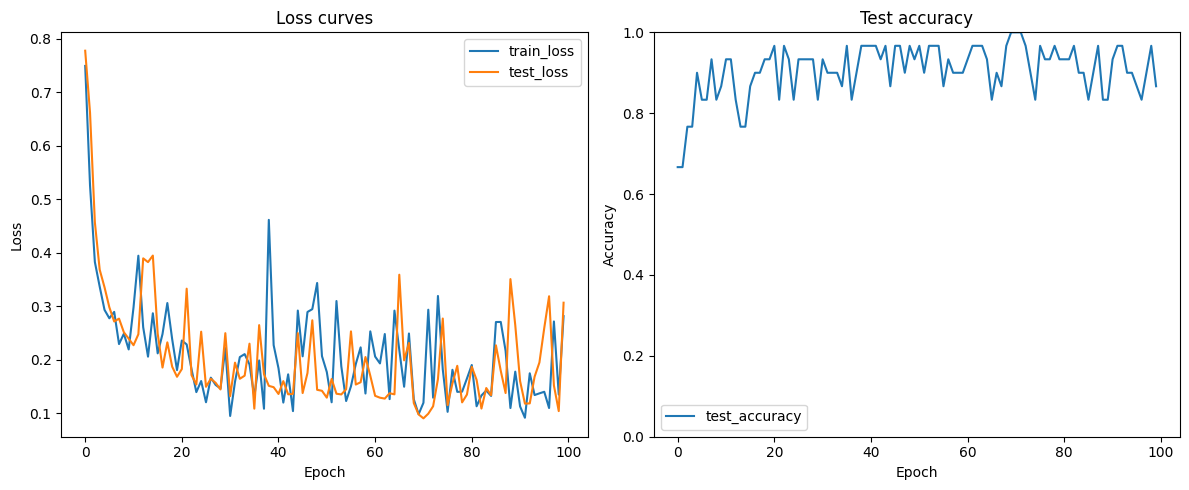

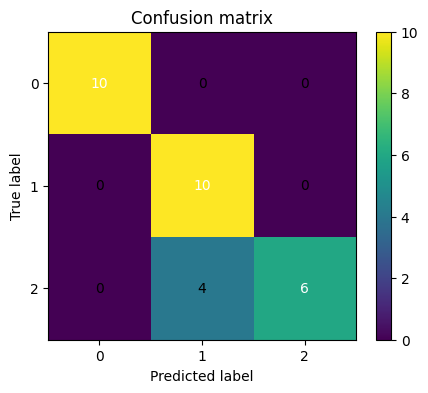

In [52]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(trainLossHistory, label="train_loss")
plt.plot(testLossHistory, label="test_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss curves")

plt.subplot(1,2,2)
plt.plot(testAccuracyHistory, label="test_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0,1.0)
plt.legend()
plt.title("Test accuracy")

plt.tight_layout()
plt.show()

plt.figure(figsize=(5,4))
plt.imshow(confusionMatrix, interpolation='nearest')
plt.title("Confusion matrix")
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.xticks([0,1,2])
plt.yticks([0,1,2])
for i in range(confusionMatrix.shape[0]):
    for j in range(confusionMatrix.shape[1]):
        plt.text(j, i, confusionMatrix[i, j], ha="center", va="center", color="white" if confusionMatrix[i,j] > confusionMatrix.max()/2 else "black")
plt.show()
